In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

The code will run on GPU.


## Create dataset and dataloaders

In [43]:
data_path = '/dtu/datasets1/02514/isic/train_allstyles'
class ISIC(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=data_path):
        'Initialization'
        self.transform = transform
        image_paths = os.listdir(os.path.join(data_path, 'Images'))
        label_paths = os.listdir(os.path.join(data_path, 'Segmentations'))

        self.couples = []
        counter = 0
        for image in image_paths:
            for label in label_paths:
                if 'DS_' in image or 'DS_' in label: continue
                if train:
                    if counter < len(image_paths)*0.8:
                        if image[:12] in label:
                            self.couples.append([os.path.join(data_path, 'Images', image), os.path.join(data_path, 'Segmentations', label)])
                else:
                    if counter >= len(image_paths)*0.8:
                        if image[:12] in label:
                            self.couples.append([os.path.join(data_path, 'Images', image), os.path.join(data_path, 'Segmentations', label)]) 
            counter += 1
        print(len(self.couples))

    def __len__(self):
        'Returns the total number of samples'
        return len(self.couples)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.couples[idx][0]
        label_path = self.couples[idx][1]
        
        image = Image.open(image_path)
        label = Image.open(label_path)
        Y = self.transform(label)
        X = self.transform(image)
        return X, Y


In [44]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 6
trainset = ISIC(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = ISIC(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

240
60


### Visualization of annotations

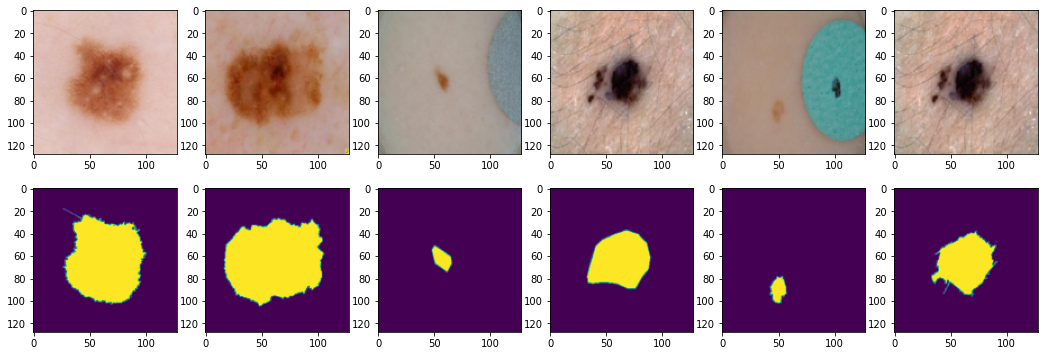

In [45]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## UNet implementation

In [47]:
class UNet2(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UNet2, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels

        self.num_channels = input_channels

        self.vgg16 = models.vgg16(pretrained=True)


        # Encoder layers

        self.encoder_conv_00 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=self.input_channels,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_01 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_02 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_10 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_11 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_12 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_20 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_21 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_22 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_23 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_30 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_31 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_32 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_33 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_40 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_41 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_42 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_43 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(512)
                                                ])

        self.init_vgg_weigts()

        # Decoder layers

        self.decoder_convtr_43 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_42 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_41 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_40 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_33 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_32 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_31 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_30 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_23 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_22 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_21 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_20 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_12 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=128,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_11 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*128,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_10 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_02 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=64,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_01 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*64,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_00 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=self.output_channels,
                                                                   kernel_size=3,
                                                                   padding=1)
                                               ])


    def forward(self, input_img):
        """
        Forward pass `input_img` through the network
        """

        # Encoder

        # Encoder Stage - 1
        dim_0 = input_img.size()
        x_00 = F.relu(self.encoder_conv_00(input_img))
        x_01 = F.relu(self.encoder_conv_01(x_00))
        x_02 = F.relu(self.encoder_conv_02(x_01))
        # x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 2
        dim_1 = x_02.size()
        x_10 = F.relu(self.encoder_conv_10(x_02))
        x_11 = F.relu(self.encoder_conv_11(x_10))
        x_12 = F.relu(self.encoder_conv_12(x_11))
        # x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 3
        dim_2 = x_12.size()
        x_20 = F.relu(self.encoder_conv_20(x_12))
        x_21 = F.relu(self.encoder_conv_21(x_20))
        x_22 = F.relu(self.encoder_conv_22(x_21))
        x_23 = F.relu(self.encoder_conv_23(x_22))
        # x_2, indices_2 = F.max_pool2d(x_22, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 4
        dim_3 = x_23.size()
        x_30 = F.relu(self.encoder_conv_30(x_23))
        x_31 = F.relu(self.encoder_conv_31(x_30))
        x_32 = F.relu(self.encoder_conv_32(x_31))
        x_33 = F.relu(self.encoder_conv_33(x_32))
        # x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 5
        dim_4 = x_33.size()
        x_40 = F.relu(self.encoder_conv_40(x_33))
        x_41 = F.relu(self.encoder_conv_41(x_40))
        x_42 = F.relu(self.encoder_conv_42(x_41))
        x_43 = F.relu(self.encoder_conv_43(x_42))
        # x_4, indices_4 = F.max_pool2d(x_42, kernel_size=2, stride=2, return_indices=True)

        # Decoder

        dim_d = x_43.size()

        # Decoder Stage - 5
        # x_4d = F.max_unpool2d(x_4, indices_4, kernel_size=2, stride=2, output_size=dim_4)
        x_43d = F.relu(self.decoder_convtr_43(x_43))
        x_4d = torch.cat((x_43d, x_42), dim=1)
        x_42d = F.relu(self.decoder_convtr_42(x_4d))
        x_41d = F.relu(self.decoder_convtr_41(x_42d))
        x_40d = F.relu(self.decoder_convtr_40(x_41d))
        dim_4d = x_40d.size()

        # Decoder Stage - 4
        # x_3d = F.max_unpool2d(x_40d, indices_3, kernel_size=2, stride=2, output_size=dim_3)
        x_33d = F.relu(self.decoder_convtr_33(x_40d))
        x_3d = torch.cat((x_33d, x_32), dim=1)
        x_32d = F.relu(self.decoder_convtr_32(x_3d))
        x_31d = F.relu(self.decoder_convtr_31(x_32d))
        x_30d = F.relu(self.decoder_convtr_30(x_31d))
        dim_3d = x_30d.size()

        # Decoder Stage - 3
        # x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
        x_23d = F.relu(self.decoder_convtr_23(x_30d))
        x_2d = torch.cat((x_23d, x_22), dim=1)
        x_22d = F.relu(self.decoder_convtr_22(x_2d))
        x_21d = F.relu(self.decoder_convtr_21(x_22d))
        x_20d = F.relu(self.decoder_convtr_20(x_21d))
        dim_2d = x_20d.size()

        # Decoder Stage - 2
        # x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
        x_12d = F.relu(self.decoder_convtr_12(x_20d))
        x_1d = torch.cat((x_12d, x_11), dim=1)
        x_11d = F.relu(self.decoder_convtr_11(x_1d))
        x_10d = F.relu(self.decoder_convtr_10(x_11d))
        dim_1d = x_10d.size()

        # Decoder Stage - 1
        # x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
        x_02d = F.relu(self.decoder_convtr_02(x_10d))
        x_0d = torch.cat((x_02d, x_01), dim=1)
        x_01d = F.relu(self.decoder_convtr_01(x_0d))
        x_00d = self.decoder_convtr_00(x_01d)
        dim_0d = x_00d.size()

        x_softmax = F.softmax(x_00d, dim=1)

        if DEBUG:
            print("dim_0: {}".format(dim_0))
            print("dim_1: {}".format(dim_1))
            print("dim_2: {}".format(dim_2))
            print("dim_3: {}".format(dim_3))
            print("dim_4: {}".format(dim_4))

            print("dim_d: {}".format(dim_d))
            print("dim_4d: {}".format(dim_4d))
            print("dim_3d: {}".format(dim_3d))
            print("dim_2d: {}".format(dim_2d))
            print("dim_1d: {}".format(dim_1d))
            print("dim_0d: {}".format(dim_0d))

        return x_00d, x_softmax

    def init_vgg_weigts(self):
        assert self.encoder_conv_00[0].weight.size() == self.vgg16.features[0].weight.size()
        self.encoder_conv_00[0].weight.data = self.vgg16.features[0].weight.data
        assert self.encoder_conv_00[0].bias.size() == self.vgg16.features[0].bias.size()
        self.encoder_conv_00[0].bias.data = self.vgg16.features[0].bias.data

        assert self.encoder_conv_01[0].weight.size() == self.vgg16.features[2].weight.size()
        self.encoder_conv_01[0].weight.data = self.vgg16.features[2].weight.data
        assert self.encoder_conv_01[0].bias.size() == self.vgg16.features[2].bias.size()
        self.encoder_conv_01[0].bias.data = self.vgg16.features[2].bias.data

        assert self.encoder_conv_10[0].weight.size() == self.vgg16.features[5].weight.size()
        self.encoder_conv_10[0].weight.data = self.vgg16.features[5].weight.data
        assert self.encoder_conv_10[0].bias.size() == self.vgg16.features[5].bias.size()
        self.encoder_conv_10[0].bias.data = self.vgg16.features[5].bias.data

        assert self.encoder_conv_11[0].weight.size() == self.vgg16.features[7].weight.size()
        self.encoder_conv_11[0].weight.data = self.vgg16.features[7].weight.data
        assert self.encoder_conv_11[0].bias.size() == self.vgg16.features[7].bias.size()
        self.encoder_conv_11[0].bias.data = self.vgg16.features[7].bias.data

        assert self.encoder_conv_20[0].weight.size() == self.vgg16.features[10].weight.size()
        self.encoder_conv_20[0].weight.data = self.vgg16.features[10].weight.data
        assert self.encoder_conv_20[0].bias.size() == self.vgg16.features[10].bias.size()
        self.encoder_conv_20[0].bias.data = self.vgg16.features[10].bias.data

        assert self.encoder_conv_21[0].weight.size() == self.vgg16.features[12].weight.size()
        self.encoder_conv_21[0].weight.data = self.vgg16.features[12].weight.data
        assert self.encoder_conv_21[0].bias.size() == self.vgg16.features[12].bias.size()
        self.encoder_conv_21[0].bias.data = self.vgg16.features[12].bias.data

        assert self.encoder_conv_22[0].weight.size() == self.vgg16.features[14].weight.size()
        self.encoder_conv_22[0].weight.data = self.vgg16.features[14].weight.data
        assert self.encoder_conv_22[0].bias.size() == self.vgg16.features[14].bias.size()
        self.encoder_conv_22[0].bias.data = self.vgg16.features[14].bias.data

        assert self.encoder_conv_30[0].weight.size() == self.vgg16.features[17].weight.size()
        self.encoder_conv_30[0].weight.data = self.vgg16.features[17].weight.data
        assert self.encoder_conv_30[0].bias.size() == self.vgg16.features[17].bias.size()
        self.encoder_conv_30[0].bias.data = self.vgg16.features[17].bias.data

        assert self.encoder_conv_31[0].weight.size() == self.vgg16.features[19].weight.size()
        self.encoder_conv_31[0].weight.data = self.vgg16.features[19].weight.data
        assert self.encoder_conv_31[0].bias.size() == self.vgg16.features[19].bias.size()
        self.encoder_conv_31[0].bias.data = self.vgg16.features[19].bias.data

        assert self.encoder_conv_32[0].weight.size() == self.vgg16.features[21].weight.size()
        self.encoder_conv_32[0].weight.data = self.vgg16.features[21].weight.data
        assert self.encoder_conv_32[0].bias.size() == self.vgg16.features[21].bias.size()
        self.encoder_conv_32[0].bias.data = self.vgg16.features[21].bias.data

        assert self.encoder_conv_40[0].weight.size() == self.vgg16.features[24].weight.size()
        self.encoder_conv_40[0].weight.data = self.vgg16.features[24].weight.data
        assert self.encoder_conv_40[0].bias.size() == self.vgg16.features[24].bias.size()
        self.encoder_conv_40[0].bias.data = self.vgg16.features[24].bias.data

        assert self.encoder_conv_41[0].weight.size() == self.vgg16.features[26].weight.size()
        self.encoder_conv_41[0].weight.data = self.vgg16.features[26].weight.data
        assert self.encoder_conv_41[0].bias.size() == self.vgg16.features[26].bias.size()
        self.encoder_conv_41[0].bias.data = self.vgg16.features[26].bias.data

        assert self.encoder_conv_42[0].weight.size() == self.vgg16.features[28].weight.size()
        self.encoder_conv_42[0].weight.data = self.vgg16.features[28].weight.data
        assert self.encoder_conv_42[0].bias.size() == self.vgg16.features[28].bias.size()
        self.encoder_conv_42[0].bias.data = self.vgg16.features[28].bias.data

In [48]:
DEBUG = False
model = UNet2(3, 1).to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
            Conv2d-5           [-1, 64, 64, 64]          36,928
       BatchNorm2d-6           [-1, 64, 64, 64]             128
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

## Loss function and train

In [49]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [50]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            # print("x_batch shape: ", X_batch.shape)
            Y_pred, _ = model(X_batch)
            # print("y_pred shape: ", len(Y_pred), len(Y_pred[0]), len(Y_pred[0][0]), len(Y_pred[0][0][0]))
            # print("y_batch shape: ", Y_batch.shape)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_test_pred, _ = model(X_test.to(device))
        Y_hat = torch.sigmoid(Y_test_pred).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [51]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

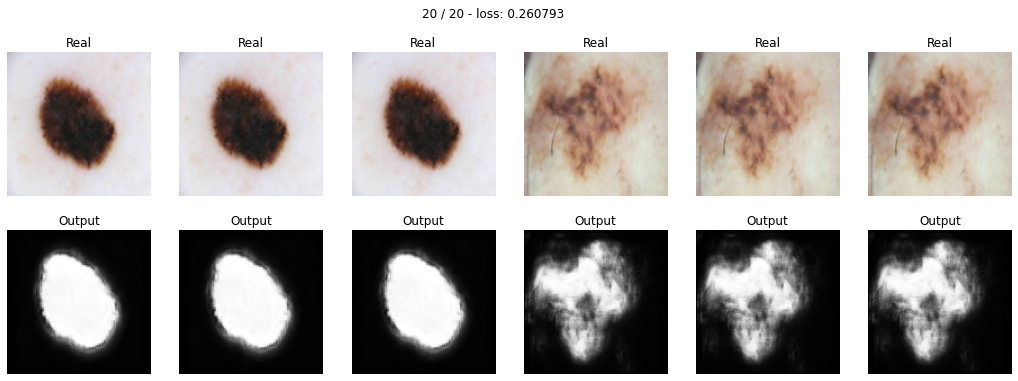

In [52]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)